In [ ]:
!pip install spacy
!pip install textblob_fr

In [349]:
import pandas as pd
from spacy.lang.fr.stop_words import STOP_WORDS
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt

df1 = pd.read_csv('2020articles.csv')
df2 = pd.read_csv('2019articles.csv')
df3 = pd.read_csv('2018articles.csv')
df4 = pd.read_csv('2021articles.csv')
articledb = pd.concat([df1,df2,df3,df4])
articledb.published_at = pd.to_datetime(articledb.published_at).dt.date
#articles_list = articledb.sort_values(by='published_at').description.dropna().to_list()

In [350]:
#creating a list of sentiment from all articles published in one day matching a query
def create_daily_sentiment(articles, start_date, query):
    #create a mask to search for articles within the desired date range
    mask = (articles.published_at > start_date-timedelta(days=1)) & (articles.published_at <= start_date)
    articles = articles.loc[mask]
    
    #clean and normalize the articles and query to prepare for parsing words
    articles['cleaned_article'] = articles['description'].replace('\n','').str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower()
    articles['cleaned_article'] = articles['cleaned_article'].replace('\t','')
    articles['cleaned_article'] = articles['cleaned_article'].replace('\r','')
    cleaned = articles.dropna(subset=['cleaned_article'])
    query = query.encode('ascii', errors='ignore').decode('utf-8').lower()
    
    #instantiate an empty query set which will be used to find articles based on words used in query
    queryset = []
    queried_articles = cleaned[cleaned.cleaned_article.str.contains(query)]
    queryset.append(queried_articles)

    #create a list of all articles that contain the query by concatenating the queryset and make the words lowercase
    cleaned = pd.concat(queryset)
    cleaned["article_text"] = cleaned["cleaned_article"].astype(str).str.lower()
    
    #create sentiment scores for each article
    article_sentiment_list = []
    textblob = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    for article in cleaned["article_text"]:
        score = textblob(article).sentiment[0]
        if (score > 0.145): #calibrated the positive score manually by reading the articles and comparing them to the given score
            article_sentiment_list.append('Positive')
        elif (score < 0):
            article_sentiment_list.append('Negative')
        else:
            article_sentiment_list.append('Neutral')
    
    #create counter of general sentiments of all the articles found from our query within a given day
    sentiment = {'Positive':0,'Negative':0,'Neutral':0}
    for index in range(len(article_sentiment_list)):
        sentiment[article_sentiment_list[index]] = article_sentiment_list.count(article_sentiment_list[index])
    cleaned['combined_sentiment'] = sentiment['Positive'] - sentiment['Negative']
    cleaned['sentiment'] = article_sentiment_list
    clean_db = cleaned.reset_index()
    return clean_db


#find articles that include search query and create a list of daily overall sentiment and add it to the query database 'querydb'
def create_sentiment_timeseries_db(start_year, start_month, start_day, date_range, search_query, articledb):
    querydb = []
    for x in range(date_range):
        start_date = date(start_year,start_month,start_day)-timedelta(days=x)
        cleandb = create_daily_sentiment(articledb, start_date, search_query)
        querydb.append(cleandb)
    querydb = pd.concat(querydb) 
    return querydb

#prepare 7 day, 30 day, and 90 day EMA and SMA to compare to the raw data for our timeseries
def create_moving_averages_db(db):
    db.set_index('published_at', inplace=True)
    db.sort_index(ascending=True, inplace=True)
    db['cumulative'] = db['combined_sentiment'].cumsum()
    db['baseline'] = 0
    db['7 day SMA'] = db['cumulative'].rolling(7).mean()
    db['7 day EMA'] = db['cumulative'].ewm(span=7,min_periods=0,adjust=False,ignore_na=False).mean()
    db['30 day SMA'] = db['cumulative'].rolling(30).mean()
    db['30 day EMA'] = db['cumulative'].ewm(span=30,min_periods=0,adjust=False,ignore_na=False).mean()
    db['90 day EMA'] = db['cumulative'].ewm(span=90,min_periods=0,adjust=False,ignore_na=False).mean()
    return db

/Users/pascalabrun/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/pascalabrun/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/pascalabrun/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

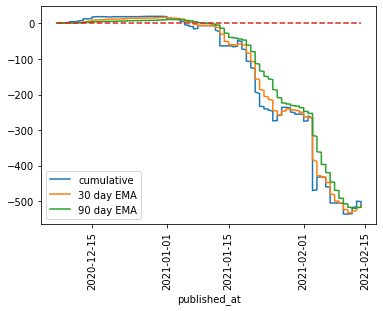

692 articles included the search query 'jovenel moise'


In [357]:
search_query = 'jovenel moise' #looking for articles mentioning the former Haitian president to find sentiment across popular Haitian news sites 

sentiment_timeseries = create_sentiment_timeseries_db(2021, 2, 14, 70, search_query, articledb)

#create the timeseries plot of our EMA and SMA sentiment values
db = create_moving_averages_db(sentiment_timeseries)
db[['cumulative','30 day EMA','90 day EMA']].plot()
db.baseline.plot(linestyle='dashed')
plt.xticks(rotation=90)
plt.show()

article_amounts = len(db.index)
print(str(article_amounts)+" articles included the search query "+"'"+search_query+"'")

<AxesSubplot:title={'center':'Sentiment Across Sources'}, xlabel='source'>

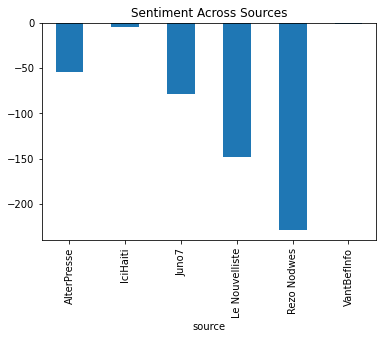

In [361]:
db.groupby('source')['combined_sentiment'].sum().plot(kind='bar', title='Sentiment Across Sources')

In [362]:
db.groupby(['source',"sentiment"])["url"].count().reset_index().reset_index(drop=True)

,source,sentiment,url
0,AlterPresse,Negative,2
1,AlterPresse,Neutral,44
2,AlterPresse,Positive,4
3,IciHaiti,Neutral,12
4,IciHaiti,Positive,4
5,Juno7,Negative,9
6,Juno7,Neutral,105
7,Juno7,Positive,20
8,Le Nouvelliste,Negative,17
9,Le Nouvelliste,Neutral,139
